In [1]:
import sqlite3
import pandas as pd
import bt
from matplotlib import pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
#stock_data.db에 접속
conn = sqlite3.connect('stock_data.db')
cursor = conn.cursor()

In [4]:
#database의 모든 데이터를 로드 
query = "SELECT ticker, 이름, 날짜, 시가, 고가, 저가, 종가, 거래량, 거래대금, 등락률, BPS, PER, PBR, EPS, DIV, DPS, 기관합계, 기타법인, 개인, 외국인합계, 전체, 시가총액, 거래량2, 거래대금2, 상장주식수, 상장주식수2, 보유수량, 지분율, 한도수량, 한도소진률 FROM stock_data WHERE 날짜 >= '2002-01-01'"

# SQL 쿼리 결과를 바로 pandas 데이터프레임으로 읽어옴 
df = pd.read_sql(query, conn, parse_dates=['날짜'])


In [5]:
# 데이터프레임을 피벗하여 각 종목별 종가 데이터를 열로 만듦
prices_df = df.pivot(index='날짜', columns='이름', values='종가')

# 데이터프레임을 피벗하여 각 종목별 PBR 데이터를 열로 만듦
pbr_df = df.pivot(index='날짜', columns='이름', values='PBR')

# 데이터프레임을 피벗하여 각 종목별 PER 데이터를 열로 만듦
per_df = df.pivot(index='날짜', columns='이름', values='PER')

In [6]:
prices_df.fillna(method='ffill', inplace=True)
pbr_df.fillna(value = 0, inplace=True)
per_df.fillna(value = 0, inplace=True)

In [31]:
class LowPBR(bt.Algo):
    def __init__(self, data_pbr, top_n=30):
        self.data_pbr = data_pbr
        self.top_n = top_n

        
    def __call__(self, target):
        # 현재 날짜의 PBR을 가져옴
        pbr = self.data_pbr.loc[target.now]

        #pbr이 0인 경우는 제외
        pbr = pbr[pbr > 0]

        # PBR이 낮은 순서대로 상위 N개 종목을 선택
        selected_stocks = pbr.sort_values().index[:self.top_n]

        target.temp['selected'] = selected_stocks

        if 'selected' not in target.temp:
            return False
        

        return True

In [32]:
class LowPER(bt.Algo):
    def __init__(self, data_per, top_n=30):
        self.data_per = data_per
        self.top_n = top_n

        
    def __call__(self, target):
        # 현재 날짜의 PBR을 가져옴
        per = self.data_per.loc[target.now]

        #pbr이 0인 경우는 제외
        per = per[per > 0]

        # PBR이 낮은 순서대로 상위 N개 종목을 선택
        selected_stocks = per.sort_values().index[:self.top_n]

        print(selected_stocks)

        target.temp['selected'] = selected_stocks

        if 'selected' not in target.temp:
            return False

        return True

In [41]:
#pbr이 x이하인 종목을 선정 algo
class LowPBR_below(bt.Algo):
    def __init__(self, data_pbr, x=3):
        self.data_pbr = data_pbr
        self.x = x
        
    def __call__(self, target):
        # 현재 날짜의 PBR을 가져옴
        pbr = self.data_pbr.loc[target.now]

        #pbr이 0인 경우는 제외
        pbr = pbr[pbr > 0]

        #pbr이 x이하인 종목을 선택
        selected_stocks = pbr[pbr <= self.x].index
 
        target.temp['selected'] = selected_stocks

        if 'selected' not in target.temp:
            return False

        return True

In [52]:
#per이 x이하인 종목을 선정 algo
class LowPER_below(bt.Algo):
    def __init__(self, data_per, x=3):
        self.data_per = data_per
        self.x = x
        
    def __call__(self, target):
        # 현재 날짜의 PBR을 가져옴
        per = self.data_per.loc[target.now]

        #per이 0인 경우는 제외
        per = per[per > 0]

        #per이 x이하인 종목을 선택
        selected_stocks = per[per <= self.x].index
 
        target.temp['selected'] = selected_stocks

        if 'selected' not in target.temp:
            return False

        return True

In [53]:
# 전략 및 백테스팅 설정
strategy = bt.Strategy('s1', [bt.algos.RunQuarterly(), bt.algos.SelectAll(), bt.algos.WeighEqually(), bt.algos.Rebalance()])
bt_backtest = bt.Backtest(strategy, prices_df)
bt_result = bt.run(bt_backtest)

Stat                 s1
-------------------  ----------
Start                2002-01-01
End                  2023-04-28
Risk-free rate       0.00%

Total Return         1923.74%
Daily Sharpe         0.80
Daily Sortino        1.22
CAGR                 15.15%
Max Drawdown         -67.48%
Calmar Ratio         0.22

MTD                  2.61%
3m                   -0.34%
6m                   11.45%
YTD                  8.32%
1Y                   -1.45%
3Y (ann.)            25.77%
5Y (ann.)            7.01%
10Y (ann.)           13.65%
Since Incep. (ann.)  15.15%

Daily Sharpe         0.80
Daily Sortino        1.22
Daily Mean (ann.)    16.54%
Daily Vol (ann.)     20.70%
Daily Skew           -0.82
Daily Kurt           7.62
Best Day             9.89%
Worst Day            -12.80%

Monthly Sharpe       0.66
Monthly Sortino      1.21
Monthly Mean (ann.)  16.98%
Monthly Vol (ann.)   25.92%
Monthly Skew         -0.15
Monthly Kurt         2.21
Best Month           24.57%
Worst Month          -33.86%


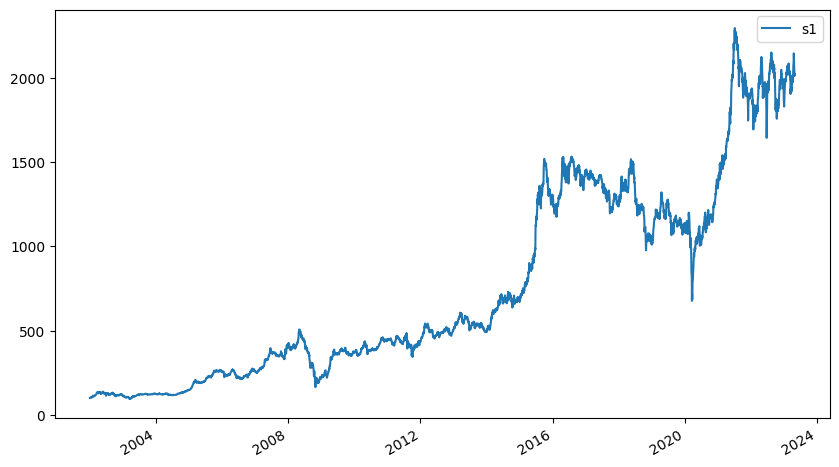

In [54]:
# 백테스팅 결과 출력
bt_result.prices.rebase().plot(figsize=(10, 6))
bt_result.display()

Index([], dtype='object', name='이름')